# 0. Описание задачи

Для освоения методов машинного обучения будем использовать базу данных интернет-магазина Sephora - ритейлера косметики и уходовых средств сегментов миддл и люкс. Будем пытаться предсказать рейтинг товара (задача восстановления регрессии) на основе цены, ингредиентов и других признаков. В датасете изначально 21 признак, но не все они влияют на рейтинг продукта (из личного опыта):

* category - категория на сайте
* brand - марка продукта 
* rating - средняя оценка пользователей (от 0 до 5 с шагом 0.5)
* price - цена (в долларах США)
* ingredients - состав


Эти признаки необходимо оставить, так как они напрямую влияют на рейтинг продукта. Состав - текстовый признак, и его нельзя разбить на категории, так как количество возможных ингредиентов очень большое, и ключевую роль играют далеко не все компоненты. Поэтому попробуем выделить из каждого состава важнейшие ингредиенты и сделать уже их категориальными признаками. 


* name - название производителя
* ID - ID продукта на сайте 
* number of reviews - количество оценок
* value_price - цена с учетом скидки
* URL - ссылка на страницу продукта
* MarketingFlags - флаг для признаков exclusive, online_only
* MarketingFlags_content
* options - можно ли выбрать оттенок и так далее
* details - доступные детали
* how_to_use - инструкция
* online_only - можно купить только через сайт
* exclusive - можно купить только в этом магазине
* love - сколько раз добавили в список желаемого

Эти же признаки не должны оказывать сильного влияния на рейтинг продукта


# 1. и 2. Исходные данные и описательная статистика

In [390]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import nltk
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.neural_network import MLPRegressor

Исходный датафрейм

In [391]:
url = 'sephora_website_dataset.csv'
data = pd.read_csv(url)
data.tail()

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,...,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer
9163,2208502,SEPHORA COLLECTION,Face Masks,The Rose Gold Mask,no size,2.0,15,6200,6.0,6.0,...,True,limited edition · exclusive,no options,What it is: A limited-edition- nurturing and h...,Suggested Usage:-Unfold the mask.-Apply the ma...,-Rose Quartz Extract: Hydrates dry skin. Aqua...,0,1,1,0
9164,2298909,SEPHORA COLLECTION,Lip Sets,Give Me Some Sugar Colorful Gloss Balm Set,3 x 0.32 oz/ 9 g,0.0,0,266,15.0,27.0,...,True,exclusive,no options,What it is: A set of three bestselling Colorfu...,Suggested Usage:-Apply directly to lips using ...,Colorful Gloss Balm Wanderlust: Hydrogenated P...,0,1,0,0
9165,2236750,SEPHORA COLLECTION,Tinted Moisturizer,Weekend Warrior Tone Up Cream,0.946 oz/ 28 mL,0.0,0,445,16.0,16.0,...,True,exclusive,no options,What it is: A weightless complexion booster- i...,Suggested Usage:-Use this product as the last ...,Aqua (Water)- Dimethicone- Isohexadecane- Poly...,0,1,0,0
9166,50,SEPHORA COLLECTION,no category,Gift Card,no size,5.0,46,0,50.0,50.0,...,False,0,no options,What it is:- Available in denominations of $10...,no instructions,unknown,0,0,0,0
9167,304,SEPHORA COLLECTION,no category,Happy Birthday Gift Card,no size,0.0,0,0,50.0,50.0,...,False,0,no options,What it is:\r\n- Available in denominations of...,no instructions,unknown,0,0,0,0


Информация о данных:

In [392]:
data.describe()

,id,rating,number_of_reviews,love,price,value_price,online_only,exclusive,limited_edition,limited_time_offer
count,9.168000e+03,9168.000000,9168.000000,9.168000e+03,9168.000000,9168.00000,9168.000000,9168.000000,9168.000000,9168.000000
mean,1.962952e+06,3.990020,282.139180,1.627859e+04,50.063237,51.82359,0.234839,0.264725,0.091841,0.000327
std,3.859714e+05,1.007707,890.642028,4.260651e+04,47.164989,49.45902,0.423921,0.441211,0.288817,0.018087
min,5.000000e+01,0.000000,0.000000,0.000000e+00,2.000000,2.00000,0.000000,0.000000,0.000000,0.000000
25%,1.819453e+06,4.000000,10.000000,1.600000e+03,24.000000,25.00000,0.000000,0.000000,0.000000,0.000000
50%,2.072354e+06,4.000000,46.000000,4.800000e+03,35.000000,35.00000,0.000000,0.000000,0.000000,0.000000
75%,2.230591e+06,4.500000,210.000000,1.380000e+04,59.000000,60.00000,0.000000,1.000000,0.000000,0.000000
max,2.359685e+06,5.000000,19000.000000,1.300000e+06,549.000000,549.00000,1.000000,1.000000,1.000000,1.000000


Средний рейтинг - 4, средняя цена - 50 долларов, минимальная - 2, максимальная - 5 

Матрица корреляции:

<AxesSubplot:>

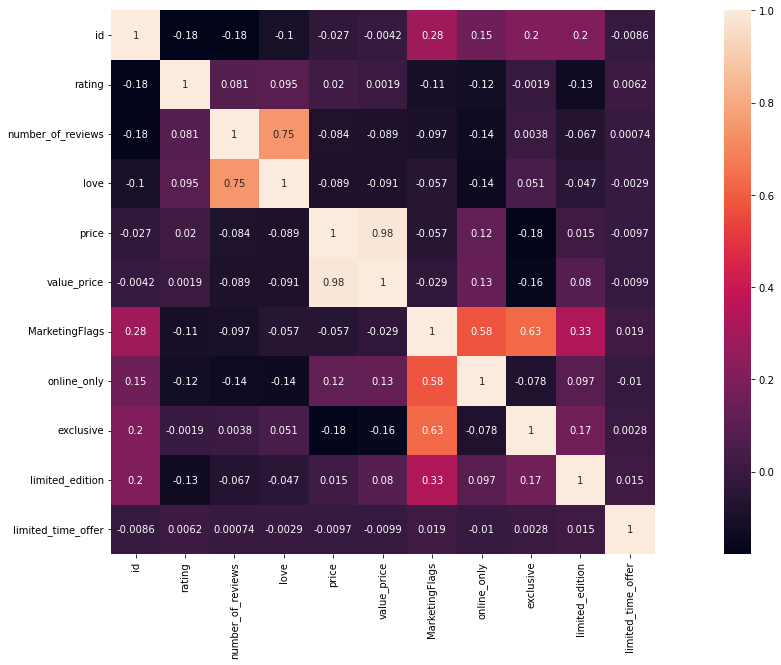

In [393]:
correlation = data.corr()
plt.figure(figsize=(25, 10))
sns.heatmap(correlation, square=True, annot=True, cmap='rocket')

Сильной корреляции почти не наблюдается - только у признаков MarketingFlag и признаков, соответствующих этому индикатору, а также у цены и той же цены с учетом скидки. У рейтинга слабая корреляция со всеми признаками

Диаграммы рассеивания для некоторых признаков

Text(0.5, 1.0, 'Зависимость рейтинга от цены')

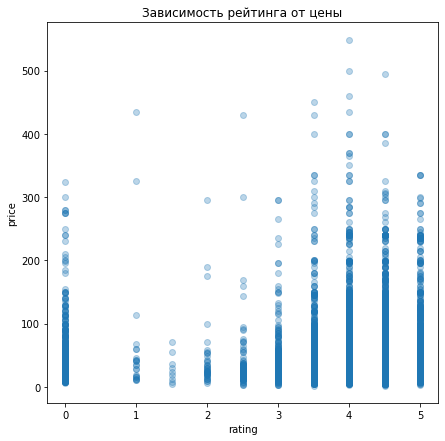

In [394]:
plt.figure(figsize=(7, 7))
plt.scatter(data['rating'], data['price'], alpha = 0.3, )
plt.xlabel('rating')
plt.ylabel('price')
plt.title('Зависимость рейтинга от цены')

Ситуация понятная - у многих продуктов еще просто нет рейтинга, никто их не оценивал. Преобладают оценки 3 и выше, ожидаемо для косметики среднего и выше ценового сегмента.

Text(0.5, 1.0, 'Зависимость количества людей, добавивших товар в список желаемого, от цены')

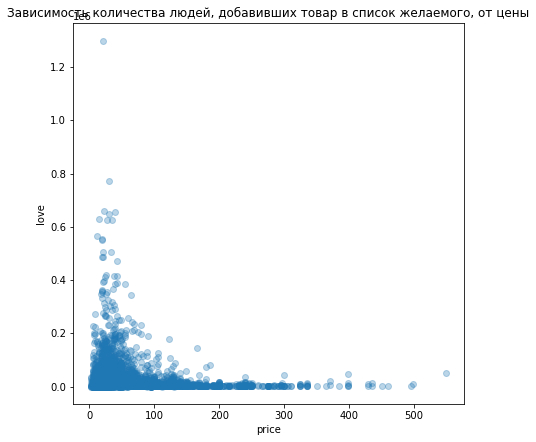

In [395]:
plt.figure(figsize=(7, 7))
plt.scatter(data['price'], data['love'], alpha = 0.3, )
plt.xlabel('price')
plt.ylabel('love')
plt.title('Зависимость количества людей, добавивших товар в список желаемого, от цены')

Чем дешевле товар, тем он популярнее в качестве планируемой покупки, также заметен выброс в левом верхнем углу диаграммы.

Text(0.5, 1.0, 'Зависимость количества людей, добавивших товар в список желаемого, от рейтинга')

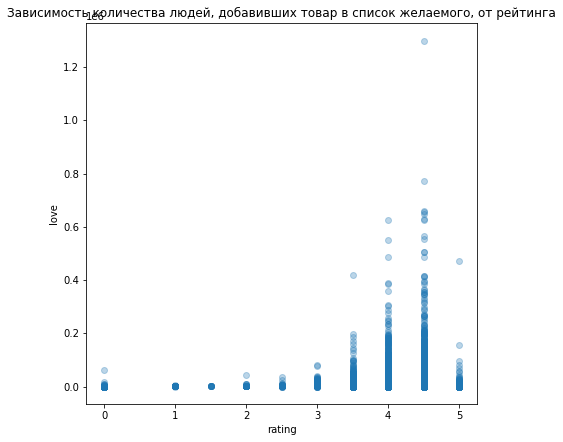

In [396]:
plt.figure(figsize=(7, 7))
plt.scatter(data['rating'], data['love'], alpha = 0.3, )
plt.xlabel('rating')
plt.ylabel('love')
plt.title('Зависимость количества людей, добавивших товар в список желаемого, от рейтинга')

Можно говорить, что покупатели присматриваются к товарам с высокой оценкой.

Text(0.5, 1.0, 'Зависимость числа отзывов от цены')

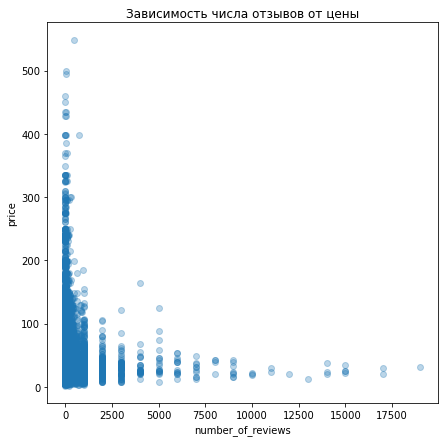

In [397]:
plt.figure(figsize=(7, 7))
plt.scatter(data['number_of_reviews'], data['price'], alpha = 0.3, )
plt.xlabel('number_of_reviews')
plt.ylabel('price')
plt.title('Зависимость числа отзывов от цены')

В среднем оставляют менее 2000 оценок, дорогие продукты оценивают реже (соответственно покупают реже).

# 3. Работа с пропущенными значениями

In [398]:
data.isna().sum()

id                        0
brand                     0
category                  0
name                      0
size                      0
rating                    0
number_of_reviews         0
love                      0
price                     0
value_price               0
URL                       0
MarketingFlags            0
MarketingFlags_content    0
options                   0
details                   0
how_to_use                0
ingredients               0
online_only               0
exclusive                 0
limited_edition           0
limited_time_offer        0
dtype: int64

Пропущенных числовых значений нет. Но есть товары без рейтинга!

In [399]:
Counter(data['rating'])

Counter({4.0: 2853,
         4.5: 3527,
         3.5: 1051,
         5.0: 872,
         3.0: 308,
         0.0: 398,
         2.5: 88,
         2.0: 39,
         1.0: 23,
         1.5: 9})

In [400]:
for i in range(len(data)):
    if data['rating'][i] == 0.0:
        data=data.drop(i, axis=0)
Counter(data['rating'])

Counter({4.0: 2853,
         4.5: 3527,
         3.5: 1051,
         5.0: 872,
         3.0: 308,
         2.5: 88,
         2.0: 39,
         1.0: 23,
         1.5: 9})

In [401]:
data=data.set_index(np.array(range(len(data))))
data

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,...,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer
0,2218774,Acqua Di Parma,Fragrance,Blu Mediterraneo MINIATURE Set,5 x 0.16oz/5mL,4.0,4,3002,66.0,75.0,...,True,online only,no options,This enchanting set comes in a specially handc...,Suggested Usage:-Fragrance is intensified by t...,Arancia di Capri Eau de Toilette: Alcohol Dena...,1,0,0,0
1,2044816,Acqua Di Parma,Cologne,Colonia,0.7 oz/ 20 mL,4.5,76,2700,66.0,66.0,...,True,online only,- 0.7 oz/ 20 mL Spray - 1.7 oz/ 50 mL Eau d...,An elegant timeless scent filled with a fresh-...,no instructions,unknown,1,0,0,0
2,1417567,Acqua Di Parma,Perfume,Arancia di Capri,5 oz/ 148 mL,4.5,26,2600,180.0,180.0,...,True,online only,- 1oz/30mL Eau de Toilette - 2.5 oz/ 74 mL E...,Fragrance Family: Fresh Scent Type: Fresh Citr...,no instructions,Alcohol Denat.- Water- Fragrance- Limonene- Li...,1,0,0,0
3,1417617,Acqua Di Parma,Perfume,Mirto di Panarea,2.5 oz/ 74 mL,4.5,23,2900,120.0,120.0,...,True,online only,- 1 oz/ 30 mL Eau de Toilette Spray - 2.5 oz/...,Panarea near Sicily is an an island suspended ...,no instructions,unknown,1,0,0,0
4,2218766,Acqua Di Parma,Fragrance,Colonia Miniature Set,5 x 0.16oz/5mL,3.5,2,943,72.0,80.0,...,True,online only,no options,The Colonia Miniature Set comes in an iconic A...,Suggested Usage:-Fragrance is intensified by t...,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8765,2149847,SEPHORA COLLECTION,Bath Soaks & Bubble Bath,Fizzing Bath Star Mini - Surprise Flowers,0.53oz/15g,3.5,11,2100,2.0,2.0,...,True,exclusive · online only,no options,What it is: A fizzing star that dissolves int...,Suggested Usage:-Place the fizzing star in the...,Sodium Bicarbonate- Citric Acid- CI 77891 (Tit...,1,1,0,0
8766,1601111,SEPHORA COLLECTION,Brush Sets,Face the Day: Full Face Brush Set,no size,3.5,62,32900,49.0,95.0,...,True,limited edition · exclusive,no options,What it is:\r\nA six-piece brush set designed ...,no instructions,unknown,0,1,1,0
8767,2149839,SEPHORA COLLECTION,Scrub & Exfoliants,Exfoliating Body Granita Scrub - Surprise Flowers,8.45oz/250mL,3.5,39,6900,8.0,8.0,...,True,exclusive · online only,no options,What it is: An indulgent- yet gentle exfoliat...,Suggested Usage:-Apply to wet skin.-Massage in...,Water- Glycerin- Cellulose Acetate- Sodium Lau...,1,1,0,0
8768,2208502,SEPHORA COLLECTION,Face Masks,The Rose Gold Mask,no size,2.0,15,6200,6.0,6.0,...,True,limited edition · exclusive,no options,What it is: A limited-edition- nurturing and h...,Suggested Usage:-Unfold the mask.-Apply the ma...,-Rose Quartz Extract: Hydrates dry skin. Aqua...,0,1,1,0


# 4. Обработка категориальных признаков (и всех данных)

Удалим столбцы, не влияющие или слабо влияющие на рейтинг продукта

In [402]:
data = data.drop([
'name',
'id',
'number_of_reviews', #поскольку задача предсказать рейтинг у нового продукта, это ни к чему
'value_price',
'URL',
'MarketingFlags',
'MarketingFlags_content',
'options',
'details',
'how_to_use',
'online_only',
'love',
'exclusive', 'size'], axis = 1)

In [403]:
brands = dict(Counter(data['brand']))
brands

{'Acqua Di Parma': 29,
 'AERIN': 21,
 'Aether Beauty': 6,
 'Algenist': 51,
 'Alpha-H': 13,
 'alpyn beauty': 5,
 'ALTERNA Haircare': 42,
 'amika': 63,
 'AMOREPACIFIC': 31,
 'Anastasia Beverly Hills': 68,
 'Anthony': 14,
 'Antonym': 3,
 'Aquis': 5,
 'Armani Beauty': 55,
 'The Art of Shaving': 15,
 'Artis': 19,
 'Artist Couture': 8,
 'Atelier Cologne': 44,
 'BALENCIAGA': 2,
 'bareMinerals': 57,
 'Beachwaver': 1,
 'The Beauty Chef': 7,
 'BeautyBio': 24,
 'beautyblender': 26,
 'BECCA': 35,
 'belif': 28,
 'Benefit Cosmetics': 90,
 'BERDOUES': 14,
 'Bésame Cosmetics': 2,
 'Better Not Younger': 14,
 'Bio Ionic': 12,
 'Biossance': 21,
 'Bite Beauty': 12,
 'bkr': 1,
 'Black Up': 5,
 'Blinc': 3,
 'Bobbi Brown': 74,
 'boscia': 20,
 'Briogeo': 47,
 'Bumble and bumble': 101,
 'BURBERRY': 25,
 'Buxom': 6,
 'BVLGARI': 24,
 'By Rosie Jane': 20,
 'Calvin Klein': 9,
 'Capri Blue': 12,
 'Carolina Herrera': 12,
 'Caudalie': 54,
 'Cellu-cup': 1,
 'CHANEL': 52,
 'Charlotte Tilbury': 73,
 'Chloé': 21,
 'Chris

Названий много, тем не менее, бренд для задачи очень важен. Поскольку он номинальный, нельзя применить label encoding. Так как различных наименований около 300, One-hot encoding тоже будет не лучшим решением, так как некоторые бренды встречаются один раз или около того (а такие значения важны: предсказать рейтинг у неизвестной марки более актуальная задача, чем, например, у именитого бренда, с ним и так всё понятно). Поэтому заменим названия брендов в столбце на частоту, с которой они встречаются в датасете.

In [404]:
for i in range(len(data)):
    data['brand'][i] = brands[data['brand'][i]]

C:\Users\matve\AppData\Local\Temp/ipykernel_16436/4013565820.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['brand'][i] = brands[data['brand'][i]]


In [405]:
data.head(20)

,brand,category,rating,price,ingredients,limited_edition,limited_time_offer
0,29,Fragrance,4.0,66.0,Arancia di Capri Eau de Toilette: Alcohol Dena...,0,0
1,29,Cologne,4.5,66.0,unknown,0,0
2,29,Perfume,4.5,180.0,Alcohol Denat.- Water- Fragrance- Limonene- Li...,0,0
3,29,Perfume,4.5,120.0,unknown,0,0
4,29,Fragrance,3.5,72.0,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,0,0
5,29,Perfume,4.5,180.0,unknown,0,0
6,29,Perfume,4.5,210.0,unknown,0,0
7,29,Cologne,5.0,120.0,Alcohol Denat.- Water- Fragrance- Limonene- Hy...,0,0
8,29,Body Mist & Hair Mist,4.0,58.0,Alcohol Denat.- Water- Fragrance- Polyquaterni...,0,0
9,29,Perfume,3.0,58.0,unknown,0,0


Категория товара может оказывать влияние на рейтинг продукта: если мы знаем, что это продукт для бровей от известной компании (специализирующейся на этом) с хорошими оценками и высокой ценой - можно гарантировать высокий рейтинг. Однако какие-нибудь уходовые средства от них же не будут такими же удачными. Поэтому из множества различных категорий товаров выделим продукты для ухода, для макияжа, продукты для волос, для тела и ванны, инструменты и кисточки, всё остальное. 

In [406]:
cat = Counter(data['category'])
cat

Counter({'Fragrance': 10,
         'Cologne': 154,
         'Perfume': 656,
         'Body Mist & Hair Mist': 29,
         'Body Lotions & Body Oils': 108,
         'Body Sprays & Deodorant': 18,
         'Perfume Gift Sets': 104,
         'Rollerballs & Travel Size': 220,
         'Lip Balm & Treatment': 81,
         'Lotions & Oils': 91,
         'Eye Palettes': 199,
         'Highlighter': 161,
         'Cheek Palettes': 30,
         'Lipstick': 188,
         'Face Serums': 378,
         'Moisturizers': 442,
         'Value & Gift Sets': 316,
         'Eye Creams & Treatments': 189,
         'Face Sunscreen': 74,
         'Lip Balms & Treatments': 78,
         'Face Masks': 226,
         'Face Wash & Cleansers': 245,
         'Decollete & Neck Creams': 10,
         'Face Oils': 83,
         'Hand Cream & Foot Cream': 26,
         'Face Primer': 143,
         'Color Correct': 10,
         'Mists & Essences': 80,
         'Tinted Moisturizer': 16,
         'Concealer': 100,
         '

In [407]:
len(data['category'].unique())

143

In [408]:
new_categories = {
    'skincare' : ['Lip Balm & Treatment', 'Face Serums', 'Moisturizers', 'Eye Creams & Treatments',
         'Face Sunscreen',
         'Lip Balms & Treatments', 'Face Masks',
         'Face Wash & Cleansers',       
         'Face Oils', 'Tinted Moisturizer', 'Facial Peels', 'Exfoliators', 'Toners', 'Sheet Masks', 'Skincare', 'Face Wash',
            'Skincare Sets', 'Moisturizer & Treatments', 'Eye Cream', 'Sunscreen', 'Face Sets', 'Anti-Aging', 'Eye Masks',
                 'Night Creams',  'Blemish & Acne Treatments',  'Lip Sunscreen', 'Lip Treatments', 'For Face',] ,
    
    'body_bath' : ['Body Lotions & Body Oils',
         'Body Sprays & Deodorant', 'Lotions & Oils', 'Decollete & Neck Creams', 'Hand Cream & Foot Cream',
                  'Body Sunscreen', 'Body Products', 'Shaving', 'Aftershave', 'Bath & Shower', 'Deodorant & Antiperspirant',
         'Holistic Wellness', 'Scrub & Exfoliants',
         'Cellulite & Stretch Marks', 'For Body',
         'Self Tanners', 'Body Wash & Shower Gel', 'Teeth Whitening',
         'Bath Soaks & Bubble Bath', 'Bath & Body', 'Deodorant for Men',
         'After Sun Care', 'Wellness',
         'Hair Removal', 'Body Moisturizers',
         'Hair Removal & Shaving', 'Spa Tools',],
    'makeup' : ['Eye Palettes',
         'Highlighter',
         'Cheek Palettes',
         'Lipstick', 'Face Primer', 'Color Correct', 'Concealer', 'Eyebrow',
         'Mascara',
         'Foundation', 'Setting Spray & Powder',
         'Contour',
         'Tweezers & Eyebrow Tools',
         'Eyeshadow',
         'Lip Gloss',
         'False Eyelashes',
         'Bronzer',
         'Eyeliner',
         'Eye Primer',
         'Eye Sets', 'Liquid Lipstick',
         'Makeup', 'Lip Liner', 'Lip Stain',
         'Lip Sets', 'Lip Plumper', 'Makeup Palettes', 'BB & CC Cream', 'BB & CC Creams', 'Blush',],
    
    'fragrance' :['Cologne',
         'Perfume',        
         'Perfume Gift Sets', 'Cologne Gift Sets', 'Candles & Home Scents', 'Candles', 'Diffusers', 'Body Mist & Hair Mist', 
                 'Mists & Essences', 'Fragrance',],
    
    'hair' : ['Conditioner',
         'Shampoo',
         'Hair Styling Products',
         'Scalp & Hair Treatments',
         'Hair Masks',
         'Hair Spray',
         'Hair Oil',
         'Hair Primers',
         'Dry Shampoo',
         'Hair',
         'Hair Thinning & Hair Loss',
         'Color Care', 'Hair Styling & Treatments', 'Curls & Coils', 'Shampoo & Conditioner','Hair Products', 'Leave-In Conditioner',],
    'tools' : ['Curling Irons', 'Hair Straighteners & Flat Irons', 'Hair Dryers', 'Hair Brushes & Combs', 'High Tech Tools',
            'Eye Brushes',
         'Face Brushes',
         'Sponges & Applicators',
         'Mirrors & Sharpeners',
         'Brush Sets',
         'Brush Cleaners',
         'Lip Brushes',
        'Facial Rollers',
            'Face Wipes',
         'Makeup & Travel Cases',
              'Makeup Removers',
         'Blotting Papers',
              'Nail',
              'Facial Cleansing Brushes',
         'Cleansing Brushes',
              'Eyelash Curlers',
         'Makeup Bags & Travel Cases',
              'Powder Brush',
         'Lid Shadow Brush'],
    'other' : ['Hair Accessories', 'no category',
         'Rollerballs & Travel Size',  'Value & Gift Sets',
         'Mini Size',
         'Beauty Supplements',  'Accessories',
         ],
}

In [409]:
for i in range(len(data)):
    for j in new_categories.items():
        if data['category'][i] in j[1]:
            data['category'][i] = j[0]
            i+=1

C:\Users\matve\AppData\Local\Temp/ipykernel_16436/3205544800.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['category'][i] = j[0]


In [410]:
data['category']

0       fragrance
1       fragrance
2       fragrance
3       fragrance
4       fragrance
          ...    
8765    body_bath
8766        tools
8767    body_bath
8768     skincare
8769        other
Name: category, Length: 8770, dtype: object

In [411]:
data.head(20)

,brand,category,rating,price,ingredients,limited_edition,limited_time_offer
0,29,fragrance,4.0,66.0,Arancia di Capri Eau de Toilette: Alcohol Dena...,0,0
1,29,fragrance,4.5,66.0,unknown,0,0
2,29,fragrance,4.5,180.0,Alcohol Denat.- Water- Fragrance- Limonene- Li...,0,0
3,29,fragrance,4.5,120.0,unknown,0,0
4,29,fragrance,3.5,72.0,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,0,0
5,29,fragrance,4.5,180.0,unknown,0,0
6,29,fragrance,4.5,210.0,unknown,0,0
7,29,fragrance,5.0,120.0,Alcohol Denat.- Water- Fragrance- Limonene- Hy...,0,0
8,29,fragrance,4.0,58.0,Alcohol Denat.- Water- Fragrance- Polyquaterni...,0,0
9,29,fragrance,3.0,58.0,unknown,0,0


Теперь различных категорий стало значительно меньше, и можно применить кодирование по столбцам для номинальных признаков 

In [412]:
onehot = pd.get_dummies(data['category'])
data = data.drop('category', axis=1)
data = data.join(onehot)

In [413]:
data.head(20)

,brand,rating,price,ingredients,limited_edition,limited_time_offer,body_bath,fragrance,hair,makeup,other,skincare,tools
0,29,4.0,66.0,Arancia di Capri Eau de Toilette: Alcohol Dena...,0,0,0,1,0,0,0,0,0
1,29,4.5,66.0,unknown,0,0,0,1,0,0,0,0,0
2,29,4.5,180.0,Alcohol Denat.- Water- Fragrance- Limonene- Li...,0,0,0,1,0,0,0,0,0
3,29,4.5,120.0,unknown,0,0,0,1,0,0,0,0,0
4,29,3.5,72.0,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,0,0,0,1,0,0,0,0,0
5,29,4.5,180.0,unknown,0,0,0,1,0,0,0,0,0
6,29,4.5,210.0,unknown,0,0,0,1,0,0,0,0,0
7,29,5.0,120.0,Alcohol Denat.- Water- Fragrance- Limonene- Hy...,0,0,0,1,0,0,0,0,0
8,29,4.0,58.0,Alcohol Denat.- Water- Fragrance- Polyquaterni...,0,0,0,1,0,0,0,0,0
9,29,3.0,58.0,unknown,0,0,0,1,0,0,0,0,0


In [414]:
data.dtypes

brand                  object
rating                float64
price                 float64
ingredients            object
limited_edition         int64
limited_time_offer      int64
body_bath               uint8
fragrance               uint8
hair                    uint8
makeup                  uint8
other                   uint8
skincare                uint8
tools                   uint8
dtype: object

Поработаем с выбросами:

In [415]:
num_data = data.select_dtypes(include=['int', 'int64', 'float64'])
num_data

,rating,price,limited_edition,limited_time_offer
0,4.0,66.0,0,0
1,4.5,66.0,0,0
2,4.5,180.0,0,0
3,4.5,120.0,0,0
4,3.5,72.0,0,0
...,...,...,...,...
8765,3.5,2.0,0,0
8766,3.5,49.0,1,0
8767,3.5,8.0,0,0
8768,2.0,6.0,1,0


In [416]:
num_data.quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

,rating,price,limited_edition,limited_time_offer
0.005,2.0,6.0,0.0,0.0
0.010,2.5,6.0,0.0,0.0
0.050,3.0,12.0,0.0,0.0
0.100,3.5,16.0,0.0,0.0
0.500,4.5,35.0,0.0,0.0
0.900,4.5,98.0,0.0,0.0
0.950,5.0,139.0,1.0,0.0
0.990,5.0,240.0,1.0,0.0
0.995,5.0,295.0,1.0,0.0


In [417]:
rows_to_drop = num_data[
    (num_data['price'] < num_data['price'].quantile(0.005)) | (num_data['price'] > num_data['price'].quantile(0.995)) 
    ].index
len(rows_to_drop)

84

Имеем 128 строк с выбросами, удалим их

In [418]:
data = data.drop(rows_to_drop, axis = 0)

In [419]:
data

,brand,rating,price,ingredients,limited_edition,limited_time_offer,body_bath,fragrance,hair,makeup,other,skincare,tools
0,29,4.0,66.0,Arancia di Capri Eau de Toilette: Alcohol Dena...,0,0,0,1,0,0,0,0,0
1,29,4.5,66.0,unknown,0,0,0,1,0,0,0,0,0
2,29,4.5,180.0,Alcohol Denat.- Water- Fragrance- Limonene- Li...,0,0,0,1,0,0,0,0,0
3,29,4.5,120.0,unknown,0,0,0,1,0,0,0,0,0
4,29,3.5,72.0,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8764,465,4.0,12.0,Water- Glycerin- Dimethicone- Isopropyl Palmit...,0,0,1,0,0,0,0,0,0
8766,465,3.5,49.0,unknown,1,0,0,0,0,0,0,0,1
8767,465,3.5,8.0,Water- Glycerin- Cellulose Acetate- Sodium Lau...,0,0,1,0,0,0,0,0,0
8768,465,2.0,6.0,-Rose Quartz Extract: Hydrates dry skin. Aqua...,1,0,0,0,0,0,0,1,0


# 6. Обучающая и тестовая выборки

In [477]:
#X=data.drop('rating', axis=1)
#y=data['rating']
X_train, X_test = train_test_split(data, train_size = 0.7, test_size = 0.3)

In [478]:
X_train['rating']

8377    3.5
8096    4.5
4248    3.0
6974    4.5
8694    5.0
       ... 
5598    4.5
4448    4.0
8506    4.5
852     4.0
7618    4.0
Name: rating, Length: 6080, dtype: float64

In [479]:
y_train

0       4.0
1       4.0
2       4.0
3       4.0
4       5.0
       ... 
6075    4.0
6076    5.0
6077    5.0
6078    4.5
6079    4.5
Name: rating, Length: 6080, dtype: float64

In [480]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = list(stopwords.words('english'))
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [481]:
add_to_stop = ['skin', 'formula', 'water', 'fragrance', 'product', 'sephora', 'fragranc', 'synthetic', 'extract', 'follow', 'type', 'ci', 'unknown', 'acid']
for i in add_to_stop:
    stop.append(i)

In [482]:
STOPWORDS = set(stop)

def punct_remove(text):
    return re.sub(r'[^\w\s]', '', text)

X_train['ingredients'] = X_train['ingredients'].apply(lambda x:punct_remove(x))
X_test['ingredients']  =  X_test['ingredients'].apply(lambda x:punct_remove(x))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

X_train['ingredients'] = X_train['ingredients'].apply(lambda x:remove_stopwords(x))
X_test['ingredients']  =  X_test['ingredients'].apply(lambda x:remove_stopwords(x))

In [483]:
X_train = X_train.reset_index()
X_train = X_train.drop('index', axis=1)

In [484]:
X_train['ingredients'][8]

''

In [485]:
def stemming(text):
    return ' '.join([PorterStemmer().stem(w) for w in text.split()])

X_train['ingredients'] = X_train['ingredients'].apply(lambda x:stemming(x))
X_test['ingredients']  =  X_test['ingredients'].apply(lambda x:stemming(x))

In [486]:
X_train['ingredients'][8]

''

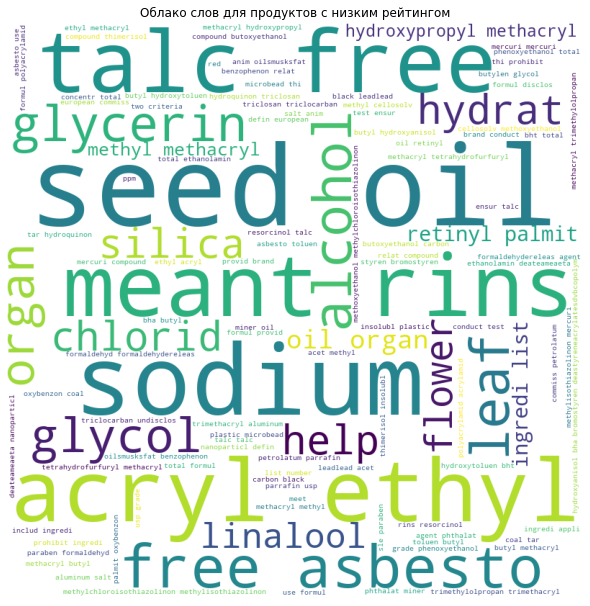

In [488]:
text = " ".join(x for x in X_train['ingredients'][(X_train['rating'] == 1.0) | (X_train['rating']==1.5) 
                                                 | (X_train['rating']==2.0)])

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text) 
                         
plt.figure(figsize = (8, 8), facecolor = "white") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Облако слов для продуктов с низким рейтингом')
plt.show()

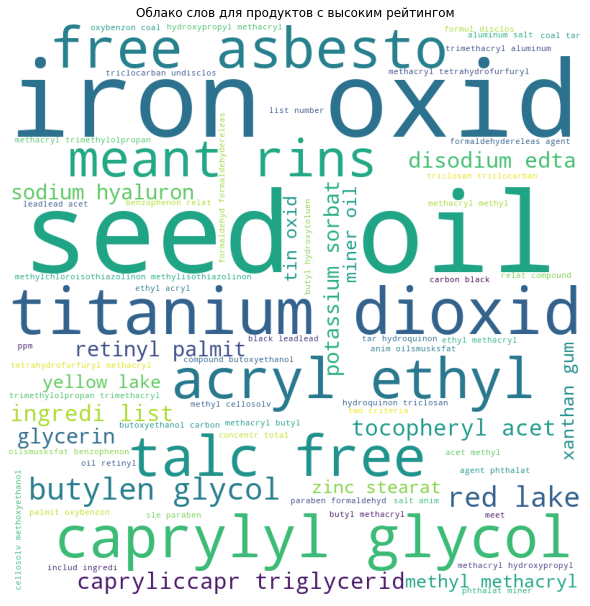

In [471]:
text = " ".join(x for x in X_train['ingredients'][ (X_train['rating']==4.5) | (X_train['rating']==5.0) ])

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text) 
                         
plt.figure(figsize = (8, 8), facecolor = "white") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Облако слов для продуктов с высоким рейтингом')
plt.show()

In [472]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5)

y_train = X_train['rating']
X_train = X_train.drop('rating', axis=1)
X_train = vectorizer.fit_transform(X_train['ingredients'])

In [473]:
y_test = X_test['rating']
X_test = X_test.drop('rating', axis=1)
X_test = vectorizer.transform(X_test['ingredients'])

In [474]:
X_test.shape

(2606, 4117)

In [441]:
X_train.shape

(6080, 4088)

# 7. и 8. K ближайших соседей и его результаты

Text(0, 0.5, 'MAE')

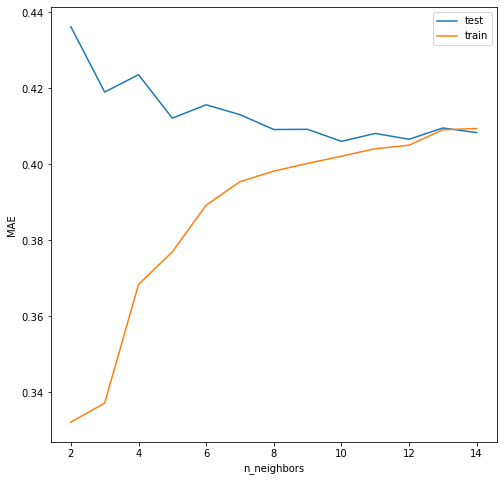

In [449]:
test_errors=[]
train_errors=[]
n_neighbors=list(range(2, 15))
for n in n_neighbors:
    model=KNeighborsRegressor(n_neighbors=n)
    model.fit(X_train, y_train)
    preds_test = model.predict(X_test)
    test_errors.append(mean_absolute_error(y_test, preds_test))
    preds_train = model.predict(X_train)
    train_errors.append(mean_absolute_error(y_train, preds_train))
plt.figure(figsize=(8,8))
plt.plot(n_neighbors, test_errors)
plt.plot(n_neighbors, train_errors)
plt.legend(['test', 'train'])
plt.xlabel('n_neighbors')
plt.ylabel('MAE')

# 9. Другие модели

Text(0, 0.5, 'MAE')

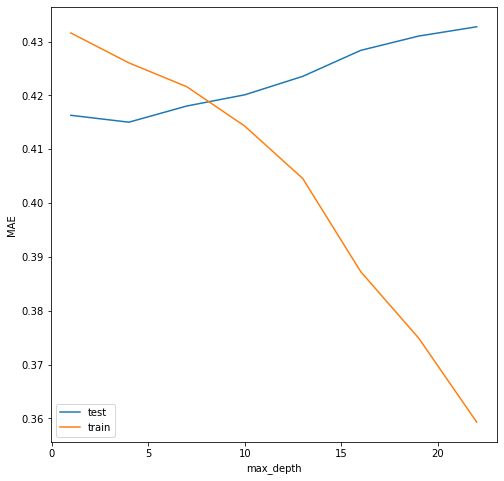

In [452]:
test_errors=[]
train_errors=[]
max_depth=list(range(1, 25, 3))
for n in max_depth:
    model=DecisionTreeRegressor(max_depth=n)
    model.fit(X_train, y_train)
    preds_test = model.predict(X_test)
    test_errors.append(mean_absolute_error(y_test, preds_test))
    preds_train = model.predict(X_train)
    train_errors.append(mean_absolute_error(y_train, preds_train))
plt.figure(figsize=(8,8))
plt.plot(max_depth, test_errors)
plt.plot(max_depth, train_errors)
plt.legend(['test', 'train'])
plt.xlabel('max_depth')
plt.ylabel('MAE')

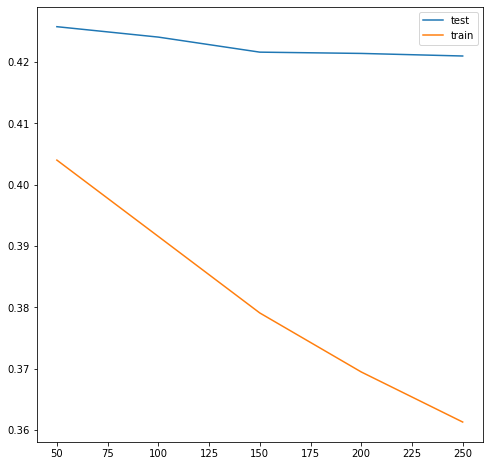

In [475]:
test_errors=[]
train_errors=[]
n_est=list(range(50, 300, 50))
for n in n_estimators:
    model=GradientBoostingRegressor(n_estimators=n)
    model.fit(X_train, y_train)
    preds_test = model.predict(X_test)
    test_errors.append(mean_absolute_error(y_test, preds_test))
    preds_train = model.predict(X_train)
    train_errors.append(mean_absolute_error(y_train, preds_train))
plt.figure(figsize=(8,8))
plt.plot(n_est, test_errors)
plt.plot(n_est, train_errors)
plt.legend(['test', 'train'])

MLPRegressor

In [455]:
test_errors=[]
train_errors=[]
neurons = list(range(1, 25))
for i in neurons:
    model = MLPRegressor(hidden_layer_sizes = (i, ), random_state=1, max_iter=500)
    model.fit(X_train, y_train)
    preds_test = model.predict(X_test)
    test_errors.append(mean_absolute_error(y_test, preds_test))
    preds_train = model.predict(X_train)
    train_errors.append(mean_absolute_error(y_train, preds_train))

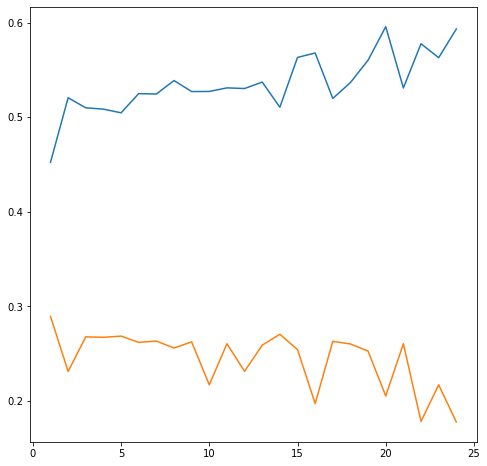

In [456]:
plt.figure(figsize=(8,8))
plt.plot(neurons, test_errors)
plt.plot(neurons, train_errors)

In [457]:
test_errors=[]
train_errors=[]
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.8, 1, 2]
for i in alphas:
    model = MLPRegressor(hidden_layer_sizes = (3, ), alpha=i, random_state=1, max_iter=500)
    model.fit(X_train, y_train)
    preds_test = model.predict(X_test)
    test_errors.append(mean_absolute_error(y_test, preds_test))
    preds_train = model.predict(X_train)
    train_errors.append(mean_absolute_error(y_train, preds_train))

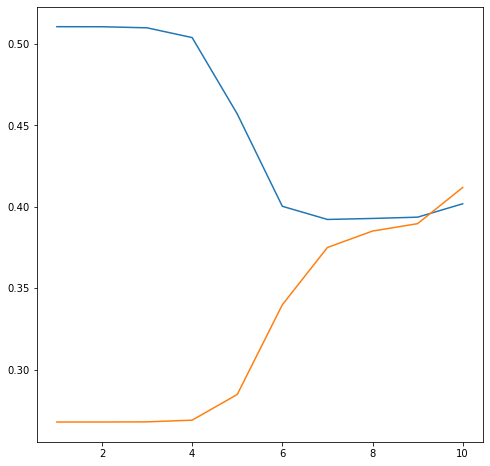

In [458]:
alphas =[1, 2, 3, 4, 5, 6, 7 , 8, 9, 10]
plt.figure(figsize=(8,8))
plt.plot(alphas, test_errors)
plt.plot(alphas, train_errors)